In [3]:
from google.colab import files
import zipfile
import os

# Upload the ZIP file
# uploaded = files.upload()

# Specify the path to the ZIP file
# zip_path = list(uploaded.keys())[0]
zip_path = '/content/dataset_transformed.zip'

extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

for root, dirs, files in os.walk(extract_path):
    for name in files:
        print(os.path.join(root, name))


Files extracted to /content/
/content/dataset_transformed.zip
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/gce
/content/.config/default_configs.db
/content/.config/.last_opt_in_prompt.yaml
/content/.config/config_sentinel
/content/.config/.last_update_check.json
/content/.config/active_config
/content/.config/.last_survey_prompt.yaml
/content/.config/configurations/config_default
/content/.config/logs/2024.11.22/14.22.38.495163.log
/content/.config/logs/2024.11.22/14.22.27.331185.log
/content/.config/logs/2024.11.22/14.22.39.624516.log
/content/.config/logs/2024.11.22/14.22.06.423354.log
/content/.config/logs/2024.11.22/14.22.50.932478.log
/content/.config/logs/2024.11.22/14.22.50.282297.log
/content/dataset_transformed/train/images/ed/disease_1/ed_disease_1_146.jpg
/content/dataset_transformed/train/images/ed/disease_1/ed_disease_1_4.jpg
/content/dataset_transformed/train/images/ed/disease_1/ed_disease_1_56.jpg
/content/dataset_trans

In [ ]:
import shutil
import os

directory_to_delete = '/content/dataset_transformed'

if os.path.exists(directory_to_delete):
    shutil.rmtree(directory_to_delete)
    print(f"Directory {directory_to_delete} and its contents have been deleted.")
else:
    print(f"Directory {directory_to_delete} does not exist.")


In [5]:
# Import necessary libraries
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [6]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
class CardiacMRIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.jpg'))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        if 'disease_1' in img_path:
            label = 1
        elif 'disease_2' in img_path:
            label = 2
        else:
            label = 0

        return image, mask, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

In [9]:
def create_data_loaders(image_dirs, mask_dirs, batch_size=4, shuffle=True):
    datasets = []
    for image_dir, mask_dir in zip(image_dirs, mask_dirs):
        dataset = CardiacMRIDataset(image_dir=image_dir, mask_dir=mask_dir, transform=transform)
        datasets.append(dataset)

    combined_dataset = torch.utils.data.ConcatDataset(datasets)
    data_loader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=shuffle)
    return data_loader


In [10]:
train_image_dirs = [
    '/content/dataset_transformed/train/images/ed/normal',
    '/content/dataset_transformed/train/images/ed/disease_1',
    '/content/dataset_transformed/train/images/ed/disease_2',
    '/content/dataset_transformed/train/images/es/normal',
    '/content/dataset_transformed/train/images/es/disease_1',
    '/content/dataset_transformed/train/images/es/disease_2'
]

train_mask_dirs = [
    '/content/dataset_transformed/train/masks/ed/normal',
    '/content/dataset_transformed/train/masks/ed/disease_1',
    '/content/dataset_transformed/train/masks/ed/disease_2',
    '/content/dataset_transformed/train/masks/es/normal',
    '/content/dataset_transformed/train/masks/es/disease_1',
    '/content/dataset_transformed/train/masks/es/disease_2'
]

val_image_dirs = [
    '/content/dataset_transformed/val/images/ed/normal',
    '/content/dataset_transformed/val/images/ed/disease_1',
    '/content/dataset_transformed/val/images/ed/disease_2',
    '/content/dataset_transformed/val/images/es/normal',
    '/content/dataset_transformed/val/images/es/disease_1',
    '/content/dataset_transformed/val/images/es/disease_2'
]

val_mask_dirs = [
    '/content/dataset_transformed/val/masks/ed/normal',
    '/content/dataset_transformed/val/masks/ed/disease_1',
    '/content/dataset_transformed/val/masks/ed/disease_2',
    '/content/dataset_transformed/val/masks/es/normal',
    '/content/dataset_transformed/val/masks/es/disease_1',
    '/content/dataset_transformed/val/masks/es/disease_2'
]

test_image_dirs = [
    '/content/dataset_transformed/test/images/ed',
    '/content/dataset_transformed/test/images/es'
]

test_mask_dirs = [
    '/content/dataset_transformed/test/masks/ed',
    '/content/dataset_transformed/test/masks/es'
]

In [11]:
train_loader = create_data_loaders(train_image_dirs, train_mask_dirs, batch_size=4, shuffle=True)
val_loader = create_data_loaders(val_image_dirs, val_mask_dirs, batch_size=4, shuffle=False)
test_loader = create_data_loaders(test_image_dirs, test_mask_dirs, batch_size=4, shuffle=False)

In [12]:
for images, masks, labels in train_loader:
    print(images.shape, masks.shape, labels)
    break


torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256]) tensor([0, 1, 2, 2])


In [13]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        self.inc = nn.Conv2d(n_channels, 64, kernel_size=3, padding=1)
        self.down1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.down2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.down3 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.down4 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)

        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = torch.relu(self.inc(x))
        x2 = torch.relu(torch.max_pool2d(self.down1(x1), 2))
        x3 = torch.relu(torch.max_pool2d(self.down2(x2), 2))
        x4 = torch.relu(torch.max_pool2d(self.down3(x3), 2))
        x5 = torch.relu(torch.max_pool2d(self.down4(x4), 2))

        x = torch.relu(self.up1(x5))
        x = torch.relu(self.up2(x + x4))
        x = torch.relu(self.up3(x + x3))
        x = torch.relu(self.up4(x + x2))
        x = self.outc(x + x1)

        return x

In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 16 * 16, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [15]:
def dice_coefficient(pred, target, epsilon=1e-6):
    intersection = (pred * target).sum()
    return (2. * intersection + epsilon) / (pred.sum() + target.sum() + epsilon)

In [16]:
segmentation_model = UNet(n_channels=3, n_classes=1).to(device)
segmentation_criterion = nn.BCEWithLogitsLoss()
segmentation_optimizer = optim.Adam(segmentation_model.parameters(), lr=1e-4)

classification_model = SimpleCNN(num_classes=3).to(device)
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.Adam(classification_model.parameters(), lr=1e-4)

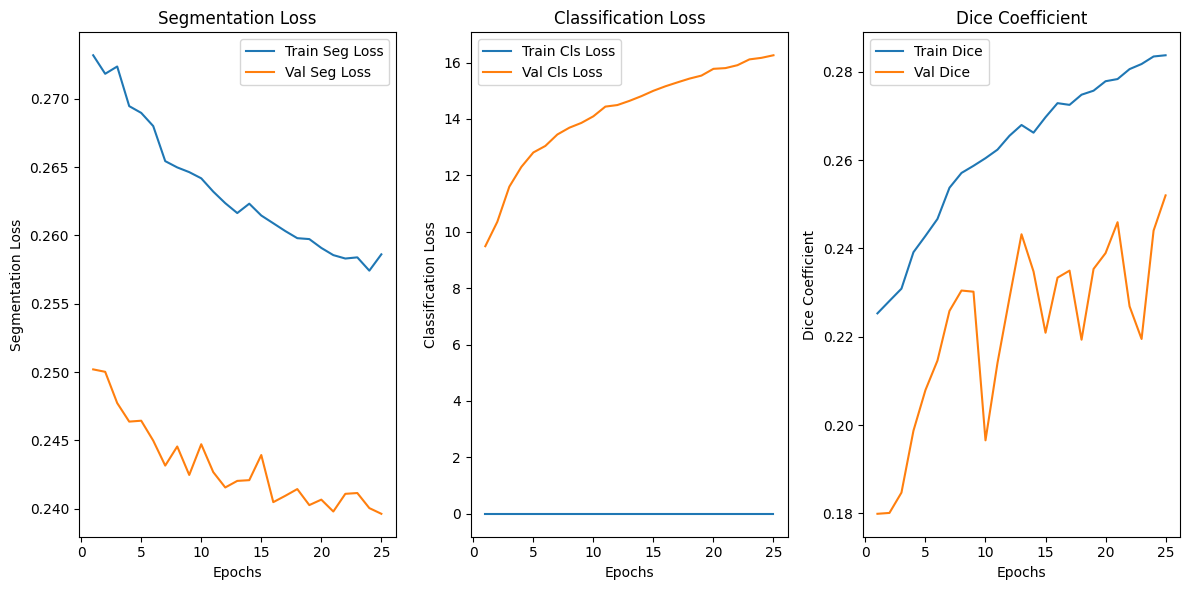

In [18]:
from IPython.display import clear_output

train_seg_losses = []
train_cls_losses = []
train_dices = []
val_seg_losses = []
val_cls_losses = []
val_dices = []

# Function to update the live plot
def plot_metrics():
    clear_output(wait=True)
    epochs = range(1, len(train_seg_losses) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_seg_losses, label='Train Seg Loss')
    plt.plot(epochs, val_seg_losses, label='Val Seg Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Segmentation Loss')
    plt.legend()
    plt.title('Segmentation Loss')

    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_cls_losses, label='Train Cls Loss')
    plt.plot(epochs, val_cls_losses, label='Val Cls Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Classification Loss')
    plt.legend()
    plt.title('Classification Loss')

    plt.subplot(1, 3, 3)
    plt.plot(epochs, train_dices, label='Train Dice')
    plt.plot(epochs, val_dices, label='Val Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    plt.title('Dice Coefficient')

    plt.tight_layout()
    plt.show()

num_epochs = 25
for epoch in range(num_epochs):
    segmentation_model.train()
    classification_model.train()
    epoch_seg_loss = 0
    epoch_cls_loss = 0
    epoch_dice = 0

    # Training loop
    for images, masks, labels in train_loader:
        images, masks, labels = images.to(device), masks.to(device), labels.to(device)

        # Segmentation training
        segmentation_optimizer.zero_grad()
        seg_outputs = segmentation_model(images)
        seg_loss = segmentation_criterion(seg_outputs, masks)
        seg_loss.backward()
        segmentation_optimizer.step()
        epoch_seg_loss += seg_loss.item()

        # Calculate Dice coefficient
        seg_outputs = torch.sigmoid(seg_outputs)
        dice = dice_coefficient(seg_outputs, masks)
        epoch_dice += dice.item()

        # Classification training
        classification_optimizer.zero_grad()
        cls_outputs = classification_model(images)
        cls_loss = classification_criterion(cls_outputs, labels)
        cls_loss.backward()
        classification_optimizer.step()
        epoch_cls_loss += cls_loss.item()

    # Record training metrics
    train_seg_losses.append(epoch_seg_loss / len(train_loader))
    train_cls_losses.append(epoch_cls_loss / len(train_loader))
    train_dices.append(epoch_dice / len(train_loader))

    # Validation
    segmentation_model.eval()
    classification_model.eval()
    val_seg_loss = 0
    val_cls_loss = 0
    val_dice = 0
    with torch.no_grad():
        for images, masks, labels in val_loader:
            images, masks, labels = images.to(device), masks.to(device), labels.to(device)

            # Segmentation validation
            seg_outputs = segmentation_model(images)
            seg_loss = segmentation_criterion(seg_outputs, masks)
            val_seg_loss += seg_loss.item()

            # Calculate Dice coefficient
            seg_outputs = torch.sigmoid(seg_outputs)
            dice = dice_coefficient(seg_outputs, masks)
            val_dice += dice.item()

            # Classification validation
            cls_outputs = classification_model(images)
            cls_loss = classification_criterion(cls_outputs, labels)
            val_cls_loss += cls_loss.item()

    # Record validation metrics
    val_seg_losses.append(val_seg_loss / len(val_loader))
    val_cls_losses.append(val_cls_loss / len(val_loader))
    val_dices.append(val_dice / len(val_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Seg Loss: {train_seg_losses[-1]}, Train Cls Loss: {train_cls_losses[-1]}, Train Dice: {train_dices[-1]}, '
          f'Val Seg Loss: {val_seg_losses[-1]}, Val Cls Loss: {val_cls_losses[-1]}, Val Dice: {val_dices[-1]}')

    # Update the live plot
    plot_metrics()


In [19]:
torch.save(segmentation_model.state_dict(), 'unet_model.pth')
torch.save(classification_model.state_dict(), 'classification_model.pth')

In [20]:
segmentation_model.load_state_dict(torch.load('unet_model.pth'))
classification_model.load_state_dict(torch.load('classification_model.pth'))
segmentation_model.eval()
classification_model.eval()

<ipython-input-20-7a13f772fee8>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load('unet_model.pth'))
<ipython-input-20-7a13f772f

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=131072, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=4096, out_features=4096, bias=True)
    (3): ReLU(inpla

In [22]:
def visualize_prediction(image_path):
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        seg_output = segmentation_model(image_tensor)
        cls_output = classification_model(image_tensor)
        predicted_mask = torch.sigmoid(seg_output).squeeze().cpu().numpy()
        predicted_class = torch.argmax(cls_output, dim=1).item()

    if predicted_class == 0:
        disease_label = 'Normal'
    elif predicted_class == 1:
        disease_label = 'Disease 1'
    else:
        disease_label = 'Disease 2'

    print("Predicted class : ", predicted_class)
    print("Disease label : ", disease_label)
    image_np = np.array(image)
    masked_image = image_np.copy()
    masked_image[predicted_mask > 0.5] = [255, 0, 0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Original image
    ax[0].imshow(image_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Masked image with predicted label
    ax[1].imshow(masked_image)
    ax[1].set_title('Predicted Mask')
    ax[1].axis('off')

    plt.show()


Predicted class :  2
Disease label :  Disease 2


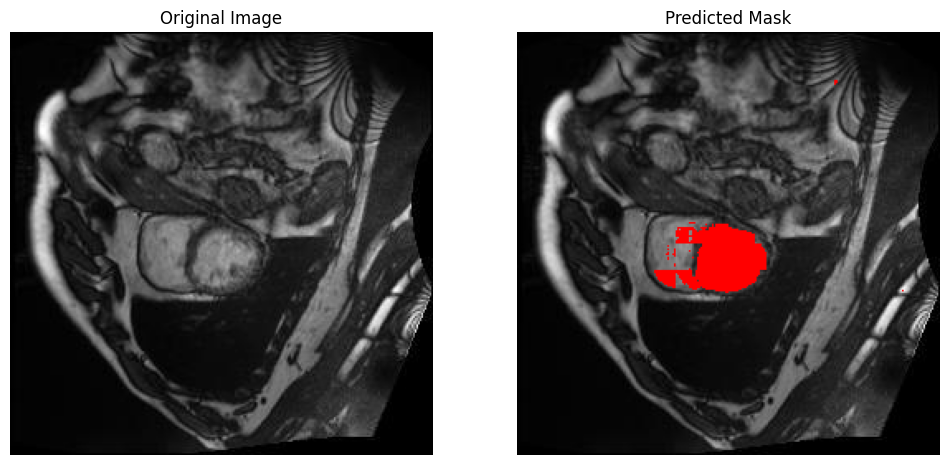

In [26]:
visualize_prediction('/content/dataset_transformed/test/images/ed/ed_3.jpg')